In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Trace inspection

In [2]:
res_dir = '../../results/SchedTuneAnalysis/'
noboost_trace = res_dir + 'trace_noboost.dat'
boost15_trace = res_dir + 'trace_boost15.dat'
boost25_trace = res_dir + 'trace_boost25.dat'

trace_file = noboost_trace
# trace_file = boost15_trace
# trace_file = boost25_trace

## Loading support data collected from the target

In [3]:
import json

# Load the platform information
with open('../../results/SchedTuneAnalysis/platform.json', 'r') as fh:
    platform = json.load(fh)
print "Platform descriptio collected from the target:"
print json.dumps(platform, indent=4)

Platform descriptio collected from the target:
{
    "nrg_model": {
        "big": {
            "cluster": {
                "nrg_max": 64
            }, 
            "cpu": {
                "cap_max": 1024, 
                "nrg_max": 616
            }
        }, 
        "little": {
            "cluster": {
                "nrg_max": 57
            }, 
            "cpu": {
                "cap_max": 447, 
                "nrg_max": 93
            }
        }
    }, 
    "clusters": {
        "big": [
            1, 
            2
        ], 
        "little": [
            0, 
            3, 
            4, 
            5
        ]
    }, 
    "cpus_count": 6, 
    "freqs": {
        "big": [
            450000, 
            625000, 
            800000, 
            950000, 
            1100000
        ], 
        "little": [
            450000, 
            575000, 
            700000, 
            775000, 
            850000
        ]
    }, 
    "topology": [
        [
         

In [4]:
from trappy.stats.Topology import Topology

# Create a topology descriptor
topology = Topology(platform['topology'])

# Workload behaviors check

## Does the task has the expected behavior?

We want to ensure that the task has the expected workload:<br>
- LITTLE CPU bandwidth of **[10, 35 and 60]%** every **2[ms]**
- activations every **32ms**
- always **starts on a big** core

### Using kernelshark

In [5]:
# Let's look at the trace using kernelshark...
!kernelshark {trace_file} 2>/dev/null

version = 6


- Requires a lot of interactions and hand made measurements
- We cannot easily annotate our findings to produre a sharable notebook

### Using the TRAPpy Trace Plotter

An overall view on the trace is still useful to get a graps on what we are looking at.

In [6]:
# Suport for FTrace events parsing and visualization
import trappy

# NOTE: The interactive trace visualization is available only if you run
#       the workload to generate a new trace-file
trappy.plotter.plot_trace(trace_file)#, execnames="task_ramp")#, pids=[1971])

## What is the task utilization?

The **sched_load_avg_task** trace events reports this information

In [7]:
# Get a list of first 5 "sched_load_avg_events" events
sched_load_avg_events = !(\
    grep sched_load_avg_task {trace_file.replace('.dat', '.txt')} | \
    head -n5 \
)
 
print "First 5 sched_load_avg events:"
for line in sched_load_avg_events:
    print line

First 5 sched_load_avg events:
       trace-cmd-1960  [000]  1176.704113: sched_load_avg_task:  comm=trace-cmd pid=1960 cpu=0 load_avg=339 util_avg=135 util_est=135 load_sum=16222383 util_sum=6452317 period_contrib=1014
       trace-cmd-1960  [000]  1176.704140: sched_load_avg_task:  comm=trace-cmd pid=1960 cpu=0 load_avg=339 util_avg=135 util_est=135 load_sum=16222383 util_sum=6452317 period_contrib=1014
          <idle>-0     [002]  1176.704396: sched_load_avg_task:  comm=sudo pid=1959 cpu=2 load_avg=0 util_avg=0 util_est=903 load_sum=6 util_sum=6 period_contrib=140
            sudo-1959  [002]  1176.704644: sched_load_avg_task:  comm=sudo pid=1959 cpu=2 load_avg=0 util_avg=0 util_est=903 load_sum=122886 util_sum=122886 period_contrib=434
          <idle>-0     [000]  1176.704847: sched_load_avg_task:  comm=rcu_preempt pid=7 cpu=0 load_avg=29 util_avg=11 util_est=12 load_sum=1418473 util_sum=556028 period_contrib=562
grep: write error


A graphical representation whould be really usefuly!

### Generate DataFrames from Trace Events

In [8]:
# Load the LISA::Trace parsing module
from trace import Trace

# Define which event we are interested into
trace = Trace(platform, trace_file, [
            "sched_switch",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_boost_cpu",
            "sched_boost_task",
            "cpu_frequency",
            "cpu_capacity",
    ])

### Get the DataFrames for the events of interest

In [9]:
# Trace events are converted into tables, let's have a look at one
# of such tables
load_df = trace.df('sched_load_avg_task')
load_df.head()

,__comm,__cpu,__pid,comm,cpu,load_avg,load_sum,period_contrib,pid,util_avg,util_est,util_sum,cluster
Time,,,,,,,,,,,,,
0.000132,trace-cmd,0,1960,trace-cmd,0,339,16222383,1014,1960,135,135,6452317,LITTLE
0.000159,trace-cmd,0,1960,trace-cmd,0,339,16222383,1014,1960,135,135,6452317,LITTLE
0.000415,<idle>,2,0,sudo,2,0,6,140,1959,0,903,6,big
0.000663,sudo,2,1959,sudo,2,0,122886,434,1959,0,903,122886,big
0.000866,<idle>,0,0,rcu_preempt,0,29,1418473,562,7,11,12,556028,LITTLE


In [10]:
# Example of events filtering
# df[df.comm == 'task_ramp'].head()

In [11]:
cap_df = trace.df('cpu_capacity')
cap_df.head()

,__comm,__cpu,__pid,cpu,capacity,max_capacity,tip_capacity
Time,,,,,,,
0.000983,kschedfreq:1,1,1490,1,1024,1024,819.2
0.000985,kschedfreq:1,1,1490,2,1024,1024,819.2
0.418931,kschedfreq:1,1,1490,1,418,1024,819.2
0.418932,kschedfreq:1,1,1490,2,418,1024,819.2
0.421914,kschedfreq:1,1,1490,1,1024,1024,819.2


### Plot the signals of interest

In [12]:
# Signals can be easily plot using the ILinePlotter
trappy.ILinePlot(
    
    # FTrace object
    trace.ftrace,
    
    # Signals to be plotted
    signals=[
      'cpu_capacity:capacity',
      'sched_load_avg_task:util_avg'
    ],
    
    # Generate one plot for each value of the specified column
     pivot='cpu',
    
    # Generate only plots which satisfy these filters
    filters={
        'comm': ['task_ramp'],
        'cpu' : [2,5]
    },
    
    # Formatting style
    per_line=2,
    drawstyle='steps-post',
    marker = '+',
    
#     sync_zoom=True,
#     group="GroupTag"

).view()

,
,


## Is the task starting on a big core?

In [13]:
from bart.sched.SchedMultiAssert import SchedAssert

# Create an object to get/assert scheduling pbehaviors
sa = SchedAssert(trace_file, topology,  execname='task_ramp')

In [14]:
# Check on which CPU the task start its execution
if sa.assertFirstCpu(platform['clusters']['big']): #, window=(4,6)):
    print "PASS: Task starts on big CPU: ", sa.getFirstCpu()
else:
    print "FAIL: Task does NOT start on a big CPU!!!"

PASS: Task starts on big CPU:  2


## Is the task generating the expected load?

We expect 35% load in the between 2 and 4 [s] of the execution

In [15]:
# Let's find when the task starts
start = sa.getStartTime()
window=(start, start+2)

print "The task starts execution at [s]: ", start
print "Window of interest: ", window

The task starts execution at [s]:  1.933234
Window of interest:  (1.9332339999998567, 3.9332339999998567)


In [16]:
import operator

# Check the task duty cycle in the second step window
if sa.assertDutyCycle(10, operator.lt, window=window):
    print "PASS: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(window))
else:
    print "FAIL: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(window))

FAIL: Task duty-cycle is 19.0439% in the [2,4] execution window


This test fails because we have not considered a scaling factor due running at a lower OPP.

To write a portable test we need to account for that condition!

In [17]:
# Get LITTLEs capacities ranges:
littles = platform['clusters']['little']
little_capacities = cap_df[cap_df.cpu.isin(littles)].capacity
min_cap = little_capacities.min()
max_cap = little_capacities.max()
print "LITTLEs capacities range: ", (min_cap, max_cap)

# Get min OPP correction factor
min_little_scale = 1.0 * min_cap / max_cap
print "LITTLE's min capacity scale: ", min_little_scale

LITTLEs capacities range:  (236, 447)
LITTLE's min capacity scale:  0.527964205817


In [18]:
# Scale the target duty-cycle according to the min OPP
target_dutycycle = 10 / min_little_scale
print "Scaled target duty-cycle: ", target_dutycycle

# Add a 1% tolerance to our test
target_dutycycle = 1.01 * target_dutycycle

print "1% tolerance scaled duty-cycle: ", target_dutycycle

Scaled target duty-cycle:  18.9406779661
1% tolerance scaled duty-cycle:  19.1300847458


In [19]:
# Check the task duty cycle in the second step window
if sa.assertDutyCycle(target_dutycycle, operator.lt, window=window):
    print "PASS: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(window))
else:
    print "FAIL: Task duty-cycle is {}% in the [2,4] execution window"\
          .format(sa.getDutyCycle(window))

PASS: Task duty-cycle is 19.0439% in the [2,4] execution window


# Advanced examples

## Is the CPU utilization always greater than the task utilization?

## Is the CPU capacity closer to the task Utilization?

We expect the CPU capacity to be the minimum possible to accomodate the task utilization in the third step

## Is the task migrated once we exceed the LITTLE CPUs capacity?

In [20]:
# Let's focus on a 15% boosted task
trappy.plotter.plot_trace(boost15_trace, execnames="task_ramp")

In [21]:
trace = Trace(platform, boost15_trace, [
            "sched_switch",
            "sched_overutilized",
            "sched_load_avg_cpu",
            "sched_load_avg_task",
            "sched_boost_cpu",
            "sched_boost_task",
            "cpu_frequency",
            "cpu_capacity",
    ])

In [22]:
from trace_analysis import TraceAnalysis

# Initialize a trace analysis module
ta = TraceAnalysis(trace, tasks=['task_ramp'], prefix='boost15_')

## What are the behaviors of the task?

Usually a common set of plots can be generated which capture the most useful information realted to a workload we are analysing

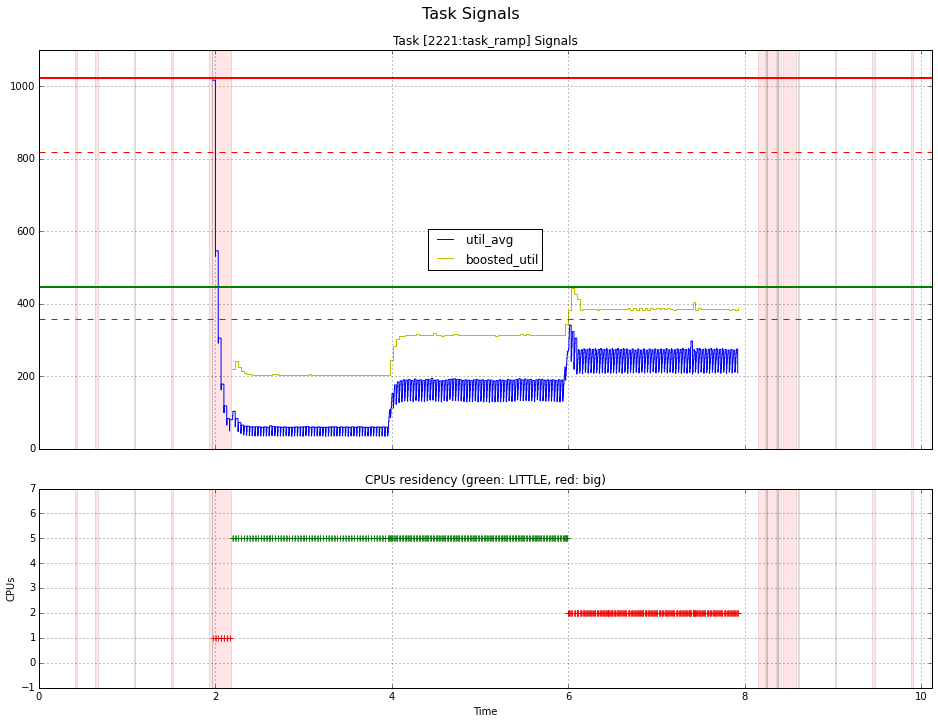

In [24]:
ta.plotTasks(
    signals=['util_avg', 'boosted_util', 'sched_overutilized', 'residencies'],
)

In [29]:
!tree {res_dir}

../../results/SchedTuneAnalysis/
├── boost15_task_util_task_ramp.png
├── energy.json
├── output.log
├── platform.json
├── rt-app-task_ramp-0.log
├── test_00.json
├── trace_boost15.dat
├── trace_boost15.raw.txt
├── trace_boost15.txt
├── trace_boost25.dat
├── trace_boost25.raw.txt
├── trace_boost25.txt
├── trace.dat
├── trace_noboost.dat
├── trace_noboost.raw.txt
├── trace_noboost.txt
├── trace.raw.txt
└── trace.txt

0 directories, 18 files


## Is the task migrating to a big core when we expect it to happen

In [30]:
# Create an object to get/assert scheduling pbehaviors
sa = SchedAssert(boost15_trace, topology,  execname='task_ramp')

In [36]:
# Let's find when the task starts
start = sa.getStartTime()

# Consider a 100 [ms] window for the task to migrate
delta = 0.1

# Defined the window of interest
switch_window=(start+4-delta, start+4+delta)

if sa.assertSwitch("cluster",
             platform['clusters']['little'],
             platform['clusters']['big'],
             window=switch_window):
    print "PASS: Task switches to big within: ", switch_window
else:
    print "PASS: Task DOES NO switches to big within: ", switch_window

PASS: Task switches to big within:  (5.8682999999999996, 6.0682999999999989)


In [46]:
import operator

if sa.assertResidency("cluster", platform['clusters']['little'], 66, operator.le, percent=True):
    print "PASS: Task exectuion on LITTLEs is {:.1f}% (less than 66% of its execution time)".\
        format(sa.getResidency("cluster", platform['clusters']['little'], percent=True))
else:
    print "FAIL: Task run on LITTLE for MORE than 66% of its execution time"

PASS: Task exectuion on LITTLEs is 53.1% (less than 66% of its execution time)


## What are the relative residency on different OPPs?

In [56]:
import pandas as pd

# Focus on cpu_frequency events for CPU0
df = trace.df('cpu_frequency')
df = df[df.cpu == 0]

# Compute the residency on each OPP before switching to the next one
df.loc[:,'start'] = df.index
df.loc[:,'delta'] = (df['start'] - df['start'].shift()).fillna(0).shift(-1)

# Group by frequency and sum-up the deltas
freq_residencies = df.groupby('frequency')['delta'].sum()
print "Residency time per OPP:"
df = pd.DataFrame(freq_residencies)

df.head()

# Compute the relative residency time
tot = sum(freq_residencies)
#df = df.apply(lambda delta : 100*delta/tot)
for f in freq_residencies.index:
    print "Freq {:10d}Hz : {:5.1f}%".format(f, 100*freq_residencies[f]/tot)

Residency time per OPP:
Freq     450000Hz :  59.3%
Freq     575000Hz :  11.7%
Freq     700000Hz :  19.5%
Freq     775000Hz :   8.8%
Freq     850000Hz :   0.6%


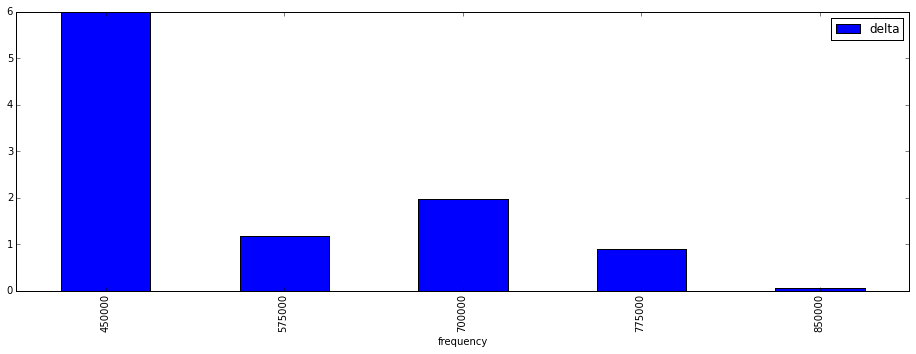

In [57]:
# Plot residency time
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 1, figsize=(16, 5));
df.plot(kind='bar', ax=axes);

<br><br><br><br>
Advanced DataFrame usage: filtering by columns/rows, merging tables, plotting data<br>
[notebooks/tutorial/05_TrappyUsage.ipynb](05_TrappyUsage.ipynb)
<br><br><br><br>